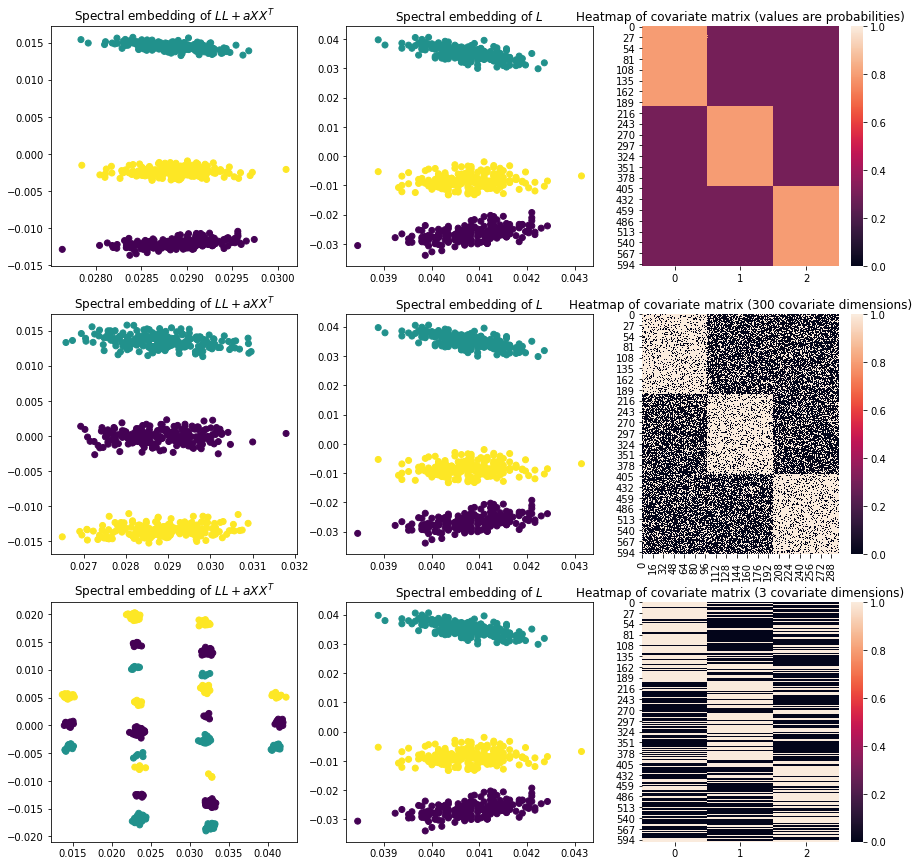

In [1]:
from graspologic.utils import import_graph, to_laplacian
from graspologic.embed.base import BaseSpectralEmbed
from graspologic.embed.lse import LaplacianSpectralEmbed
from graspologic.simulations import sbm
from graspologic.plot import heatmap

import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import seaborn as sns


class CASC(BaseSpectralEmbed):
    # TODO: everything
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.assortive_ = False
        self.is_fitted_ = False

    def fit(self, graph, covariates, y=None):
        # setup
        A = import_graph(graph)
        X = covariates.copy()

        # workhorse code
        L = to_laplacian(A, form="R-DAD")
        LL = L if self.assortive_ else L @ L
        XX = X @ X.T
        a = self._get_tuning_parameter(LL, XX)
        L_ = LL + a * (XX)
        self._reduce_dim(L_)

        self.is_fitted_ = True
        return self

    def transform(self, graph, y=None):
        A = import_graph(graph)
        pass

    def _get_tuning_parameter(self, LL, XX):
        """
        Find an a which causes the leading eigenvectors of L@L and a*X@X.T to be the same.
        """
        L_leading = np.linalg.eigvalsh(LL)[-1]
        X_leading = np.linalg.eigvalsh(XX)[-1]
        return np.float(L_leading / X_leading)


def gen_covariates(m1, m2, labels, ndim=3, static=False):
    # TODO: make sure labels is 1d array-like
    n = len(labels)

    if static:
        m1_arr = np.full(n, m1)
        m2_arr = np.full((n, ndim), m2)
        m2_arr[np.arange(n), labels] = m1_arr
    elif not static:
        m1_arr = np.random.choice([1, 0], p=[m1, 1 - m1], size=(n))
        m2_arr = np.random.choice([1, 0], p=[m2, 1 - m2], size=(n, ndim))
        m2_arr[np.arange(n), labels] = m1_arr

    return m2_arr


# setup
n = 200
n_communities = 3
p, q = 0.9, 0.3
B = np.array([[p, q, q], [q, p, q], [q, q, p]])
B2 = np.array([[q, p, p], [p, q, p], [p, p, q]])
A, labels = sbm([n, n, n], B, return_labels=True)


X = gen_covariates(0.8, 0.3, labels)
X_static = gen_covariates(0.8, 0.3, labels, static=True)

# generate nx300 array, n=200,
# where for label == 0, the first 100 covariates have prob m1, else m2
m1 = 0.8
m2 = 0.3
ndim = 300
gen_covs = lambda size: np.random.choice([1, 0], p=[m1, 1 - m1], size=size)
X_many = np.random.choice([1, 0], p=[m2, 1 - m2], size=(len(labels), ndim))
X_many[labels == 0, :100] = gen_covs(size=X_many[labels == 0, :100].shape)
X_many[labels == 1, 100:200] = gen_covs(size=X_many[labels == 1, 100:200].shape)
X_many[labels == 2, 200:] = gen_covs(size=X_many[labels == 2, 200:].shape)


Xs = [
    X_static,
    X_many,
    X,
]
l = len(Xs)
fig, axis = plt.subplots(nrows=l, ncols=3, figsize=(5 * l, 5 * l))
for i, x in enumerate(Xs):
    casc = CASC(n_components=2)
    lse = LaplacianSpectralEmbed(n_components=2)
    casc.fit(A, x)
    lse.fit(A)
    Chat = casc.latent_left_
    Ahat = lse.latent_left_
    axis[i, 0].scatter(Chat[:, 0], Chat[:, 1], c=labels)
    scatter = axis[i, 1].scatter(Ahat[:, 0], Ahat[:, 1], c=labels)
    cb = sns.heatmap(x, ax=axis[i, 2], vmin=0, vmax=1)

axis[0, 0].set_title(r"Spectral embedding of $LL + aXX^T$")
axis[0, 1].set_title(r"Spectral embedding of $L$")
axis[0, 2].set_title(r"Heatmap of covariate matrix (values are probabilities)")
axis[1, 0].set_title(r"Spectral embedding of $LL + aXX^T$")
axis[1, 1].set_title(r"Spectral embedding of $L$")
axis[1, 2].set_title(r"Heatmap of covariate matrix (300 covariate dimensions)")
axis[2, 0].set_title(r"Spectral embedding of $LL + aXX^T$")
axis[2, 1].set_title(r"Spectral embedding of $L$")
axis[2, 2].set_title(r"Heatmap of covariate matrix (3 covariate dimensions)")
plt.savefig(
    "/Users/alex/Dropbox/School/NDD/graspy-personal/figs/big.png",
    dpi=300,
    bbox_inches="tight",
)